In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn.metrics import make_scorer, confusion_matrix
import xgboost as xgb

In [2]:
data_path = os.path.join(os.getcwd(), 'ynap_data')
print(data_path)

/nfs/science/shared/ipythonNotebooks/leom/Kaggle/Ynap-master/ynap_data


In [3]:
# print(os.listdir(data_path))

In [4]:
df_tot = pd.read_csv(os.path.join(data_path, 'df_quarterly_log.csv'))
df_tot['var3'] = df_tot['var3'].astype('category')
df_tot['var5'] = df_tot['var5'].astype('category')
df_tot['var6'] = df_tot['var6'].astype('category')

# make dummies out of categorical variables
dummy_idx = np.where(df_tot.dtypes == 'category')[0]
df_dummies = pd.get_dummies(df_tot.iloc[:, dummy_idx])
df = pd.concat([df_tot.drop(df_tot.iloc[:, dummy_idx].columns.values, axis=1), df_dummies], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15695 entries, 0 to 15694
Columns: 113 entries, customer_id to var6_1.0
dtypes: float64(103), int64(2), uint8(8)
memory usage: 12.7 MB


Following the indications of the exploratory let's drop the variables we saw are highly correlated between each other.
Also let's keep only the last 6 months of data: it's more likely that this is the period where a customer could potentially become a lapser.

In [6]:
def column_finder(df, col, method=2):
    if method == 1:
        # method 1:
        cols_as_string = ' '.join(df.columns.values)
        cols_found = list(re.findall(col + '.*?\ ', cols_as_string))
        cols_found = [x.strip(' ') for x in cols_found]
    elif method == 2:
        # method 2:
        cols_found = []
        for col_elem in df.columns.values:
            if col in col_elem:
                cols_found.append(col_elem)
    else:
        raise ValueError
            
    return cols_found


def column_remover(df, col_list, noprint=False):    
    if type(col_list) != list:
        cl = []
        cl.append(col_list)
        col_list =cl
    
    col_to_remove = []
    for col in col_list:
        #print(col)
        col_to_remove.extend(column_finder(df, col, method=2))
    
    df.drop(col_to_remove, axis=1, inplace=True)
    if not noprint:
        print(col_to_remove)

In [8]:
column_remover(df, ['product_id', 'designer_id', 'gross_spend', 'item_bought', 'item_returned',
                        'ns_per_order', 'ir_per_order', 'gs_per_item', '_1989', '_199001', '_199002'
                       ], noprint=True)
# print(df_tot.columns.values)

## Balance
My objective is to get the highest recall possibile. The overall accuracy doesn't fit for this problem, because classifying the right 1s has more importance than classifying everyone correctly, whether they are 0s or 1s.
The recall measure is perfect for this problem. I want to have the highest percentage possible on classifying the customers I know are true 1s (in other words, I want to minimize the outcome set to 0 to those I know are 1), while I consider less important to have an error on those I classify 1 when they are actually 0.

Let's try different proportions of data between for not lapsed customers and lapsed customers.

In [9]:
df_for_model = df

In [10]:
X = df_for_model.drop(['customer_id', 'lapsed_next_period'], axis=1)
y = df_for_model[['customer_id', 'lapsed_next_period']]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

(15695, 27)
(15695, 2)


In [11]:
X_train_1 = X_train.loc[y_train[y_train['lapsed_next_period'] == 1].index]
X_train_0 = X_train.loc[y_train[y_train['lapsed_next_period'] == 0].index]

print(X_train_1.shape)
print(X_train_0.shape)
print(X_train_1.shape[0]/X_train.shape[0])

(657, 27)
(11899, 27)
0.05232558139534884


In [12]:
y_test[y_test['lapsed_next_period'] == 1].shape[0] / y_test.shape[0]

0.052245938196877985

In [13]:
# try different balance ratios with a couple of easy models
def balance_tester(Xtr0, Xtr1, ytr, Xte, yte, zero_quotas = [0.5, 0.66, 0.75], seeds = [21, 2121, 1212], 
                   method='log', method_params=None):
    
    if (method == 'rf') & (method_params == None):
        # Random Forest parameters
        rf_params_bal = {'n_jobs': -1, 'n_estimators': 500, 'warm_start': True, 
                         'max_depth': 4, 'min_samples_leaf': 2, 'max_features' : 'sqrt',
                         'verbose': 0}
    
    results = pd.DataFrame(columns=['quota', 'accuracy', 'pred_perc', 'recall'])
    
    for quota in zero_quotas:
        accuracy = []
        pred_perc = []
        recall = []
        
        n_sample = int(Xtr1.shape[0] * quota / (1 - quota) // 1)
        
        for seed in seeds:
            Xtr0_ = Xtr0.sample(n=n_sample, random_state=seed)
            Xtr_ = Xtr0_.append(Xtr1)
            ytr_ = ytr.loc[Xtr_.index]
            
            if method == 'log':
                clf = LogisticRegression(max_iter=100, solver='liblinear')
            elif method == 'rf':
                clf = RandomForestClassifier(**rf_params_bal)
            else:
                return 'Method not recognized'
            
            clf.fit(Xtr_, ytr_)
            clf_pred = clf.predict(Xte)
            cf = confusion_matrix(yte, clf_pred)
            
            pred_perc.append(clf_pred.sum()/len(clf_pred))
            accuracy.append(accuracy_score(yte, clf_pred))
            recall.append(cf[1, 1] / cf[1, :].sum())
            
            
        # print(np.array(accuracy).mean())
        acc_mean = np.array(accuracy).mean()
        pp_mean = np.array(pred_perc).mean()
        rec_mean = np.array(recall).mean()
        
        results = results.append(pd.Series({'quota': quota, 'accuracy': acc_mean,
                                            'pred_perc': pp_mean, 'recall': rec_mean}),
                                 ignore_index=True)
    
    return results
            
quotas = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.825, 0.85, 0.9]
# quotas = [0.8, 0.805, 0.81, 0.815, 0.82, 0.825, 0.83, 0.835, 0.84, 0.845, 0.85]
balance_res_rf = balance_tester(X_train_0, X_train_1, y_train['lapsed_next_period'], X_test, 
                                y_test['lapsed_next_period'], quotas, method='rf')

balance_res_log = balance_tester(X_train_0, X_train_1, y_train['lapsed_next_period'], X_test, 
                                y_test['lapsed_next_period'], quotas, method='log')

In [14]:
balance_res_log['acc_recall'] = 0.4 * balance_res_log['accuracy'] + 0.6 * balance_res_log['recall']
balance_res_log

,quota,accuracy,pred_perc,recall,acc_recall
0,0.500,0.735691,0.297866,0.821138,0.786959
1,0.550,0.762345,0.266752,0.778455,0.772011
2,0.600,0.781671,0.240629,0.713415,0.740717
3,0.650,0.804502,0.210152,0.640244,0.705947
4,0.700,0.831156,0.176702,0.575203,0.677585
5,0.750,0.861739,0.133376,0.453252,0.616647
6,0.800,0.890836,0.092386,0.339431,0.559993
7,0.825,0.903791,0.073059,0.278455,0.528590
8,0.850,0.913773,0.055007,0.201220,0.486241
9,0.900,0.947542,0.000212,0.000000,0.379017


In [15]:
balance_res_rf['acc_recall'] = 0.4 * balance_res_rf['accuracy'] + 0.6 * balance_res_rf['recall']
balance_res_rf

,quota,accuracy,pred_perc,recall,acc_recall
0,0.500,0.748965,0.280132,0.778455,0.766659
1,0.550,0.769035,0.257513,0.754065,0.760053
2,0.600,0.791335,0.232027,0.723577,0.750680
3,0.650,0.809600,0.208665,0.674797,0.728718
4,0.700,0.826165,0.182967,0.587398,0.682905
5,0.750,0.843899,0.158649,0.524390,0.652194
6,0.800,0.882978,0.105979,0.394309,0.589776
7,0.825,0.945843,0.006584,0.044715,0.405166
8,0.850,0.947223,0.000956,0.004065,0.381328
9,0.900,0.947754,0.000000,0.000000,0.379102


A basic proportion of 50% for not lapsed values seems to lead to good results. Let's use that for the GridSearch step.

In [16]:
quota = 0.5
n_sample = int(X_train_1.shape[0] * quota / (1 - quota) // 1)
X_train_0_ = X_train_0.sample(n=n_sample, random_state=101)

X_train_ = X_train_0_.append(X_train_1)
print(X_train_.shape)

y_train_ = y_train.loc[X_train_.index]
print(y_train_.shape)

df_ = y_train_.join(X_train_)
y_corr = df_.drop('customer_id', axis=1).corr().loc['lapsed_next_period']

(1314, 27)
(1314, 2)


In [17]:
model_cols = list(X_train_.columns.values)
print(len(model_cols))

27


In [18]:
# Logistic Regression for feature selection
log_test = LogisticRegression()
log_test = log_test.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
score_log = log_test.score(X_train_[model_cols], y_train_['lapsed_next_period'])
print(score_log)

0.77701674277


In [19]:
log_features = pd.DataFrame(list(zip(X_train_[model_cols].columns, np.transpose(log_test.coef_))))
log_features[(log_features[1] >= -0.05) & (log_features[1] <= 0.05)].sort_values(1, ascending=True)

,0,1
14,ib_per_order_199004,[-0.0213764750621]
0,var4,[-0.0210824772484]
6,net_spend_199004,[-0.00102609225257]
9,quote_var1_199003,[0.0133148643324]
10,quote_var1_199004,[0.0417052177444]


In [20]:
weak_predictors = list(log_features[(log_features[1] >= -0.05) & (log_features[1] <= 0.05)][0])
#weak_predictors.remove('var6_0.0') # I can't remove this without the other categories of the variable
print(weak_predictors)

['var4', 'net_spend_199004', 'quote_var1_199003', 'quote_var1_199004', 'ib_per_order_199004']


In [21]:
model_cols2 = [x for x in model_cols if x not in weak_predictors]
print(len(model_cols2))

22


In [22]:
# REPEAT Logistic Regression for feature selection
log_test = LogisticRegression()
log_test = log_test.fit(X_train_[model_cols2], y_train_['lapsed_next_period'])
score_log = log_test.score(X_train_[model_cols2], y_train_['lapsed_next_period'])
print(score_log)

0.777777777778


In [23]:
log_features2 = pd.DataFrame(list(zip(X_train_[model_cols2].columns, np.transpose(log_test.coef_))))
log_features2[(log_features2[1] >= -0.05) & (log_features2[1] <= 0.05)].sort_values(1, ascending=True)

,0,1
8,quote_var2_199004,[0.0264463613984]


In [24]:
# Random Forest example
rf_params = {
    'n_jobs': -1,
    'n_estimators': 200,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 4,
    'min_samples_leaf': 4,
    'max_features' : 'sqrt',
    'verbose': 0
}

rf = RandomForestClassifier(**rf_params)
rf.fit(X_train_[model_cols2], y_train_['lapsed_next_period'])

rf_pred = rf.predict(X_test[model_cols2])

print(rf_pred.sum()/len(rf_pred))

print(accuracy_score(y_test['lapsed_next_period'], rf_pred))

0.274609748327
0.753424657534


In [25]:
cf = confusion_matrix(y_test['lapsed_next_period'], rf_pred)
cf[1,1]/cf[1,:].sum()

0.76829268292682928

In [61]:
def right_classification(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    return cf[1, 1] / cf[1, :].sum()

def acc_recall_v2(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    ac = accuracy_score(y_true, y_pred)
    rc = cf[1, 1] / cf[1, :].sum()
    return (0.45 * ac + 0.65 * rc) / (abs(rc-ac) + 1)

In [62]:
# Setting multiple hyperparameters for every classifier we are going to implement

# Random Forest
rf_params_gs = {
    'n_jobs': [-1],
    'n_estimators': [100, 125, 150, 175, 200], #, 250, 300, 350, 400, 500],
    'warm_start': [True], 
     #'max_features': 0.2,
    'max_depth': [4, 5, 6],
    'min_samples_leaf': [4, 5, 6], #[2, 3]
    'max_features' : ['sqrt'],
    'verbose': [0]
}

# Extra Trees
et_params_gs = {
    'n_jobs': [-1],
    'n_estimators': [600, 650, 700, 800],
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [2, 3, 4],
    'verbose': [0]
}

# AdaBoost parameters
ada_params_gs = {
    'n_estimators': [100, 125, 150, 175, 200],
    'learning_rate': [0.03, 0.05, 0.07]
}

# Gradient Boosting parameters
gb_params_gs = {
    'n_estimators': [100, 125, 150, 175], # 200, 250, 300],
    'max_depth': [2, 3, 4, 5],
    'min_samples_leaf': [4, 5, 6],
    'verbose': [0]
}

# SVC parameters
svc_params_gs = {
    'kernel': ['linear', 'rbf'],
    'C': [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 0.01, 0.05]
}

# Logistic regression parameters
log_params_gs = {
    'solver': ['liblinear'],
    'max_iter': [100, 200, 300],
    'verbose': [0]
}

# XGBoosting parameters
xgb_params_gs = {
    'objective':['binary:logistic'],
    'learning_rate': [5e-4, 1e-3, 2e-3], #0.01], #so called `eta` value
    'max_depth': [2, 3, 4], #5, 6],
    'min_child_weight': [11],
    'silent': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'n_estimators': [300, 400, 500], #number of trees, change it to 1000 for better results
    'missing':[-999]
}

In [63]:
scoring = {'acc_recall': make_scorer(acc_recall_v2)}

In [64]:
# Istantiate the classifiers
rf = GridSearchCV(RandomForestClassifier(), rf_params_gs, cv=5, scoring=scoring, refit='acc_recall')
et = GridSearchCV(ExtraTreesClassifier(), et_params_gs, cv=5, scoring=scoring, refit='acc_recall')
ada = GridSearchCV(AdaBoostClassifier(), ada_params_gs, cv=5, scoring=scoring, refit='acc_recall')
gb = GridSearchCV(GradientBoostingClassifier(), gb_params_gs, cv=5, scoring=scoring, refit='acc_recall')
svc = GridSearchCV(SVC(), svc_params_gs, cv=5, scoring=scoring, refit='acc_recall')
log = GridSearchCV(LogisticRegression(), log_params_gs, cv=5, scoring=scoring, refit='acc_recall')
xgbm = GridSearchCV(xgb.XGBClassifier(), xgb_params_gs, cv=5, scoring=scoring, refit='acc_recall')

In [65]:
def classifier_runner(clf, Xtr, ytr, Xte, yte):
    print('-'*40)
    print(clf.estimator)
    print('-'*40)
    clf.fit(Xtr, ytr)
    clf.best_params_
    print(clf.best_params_)
    
    print()
    
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r" % (mean, std*2, params))
        
    print()
    y_true, y_pred = yte, clf.predict(Xte)
    print(classification_report(y_true, y_pred))
    print(accuracy_score(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    print(right_classification(y_true, y_pred))
    
    return clf, y_pred

In [66]:
model_cols = model_cols2

In [67]:
rf_clf, rf_ypred = classifier_runner(rf, X_train_[model_cols], y_train_['lapsed_next_period'],
                                      X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
----------------------------------------
{'n_estimators': 150, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'warm_start': True, 'verbose': 0, 'n_jobs': -1, 'max_depth': 4}


             precision    recall  f1-score   support

          0       0.98      0.74      0.84      2975
          1       0.14      0.78      0.24       164

avg / total       0.94      0.74      0.81      3139

0.742274609748
[[2202  773]
 [  36  128]]
0.780487804878


In [68]:
et_clf, et_ypred = classifier_runner(et, X_train_[model_cols], y_train_['lapsed_next_period'],
                                      X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
----------------------------------------
{'n_estimators': 650, 'n_jobs': -1, 'max_depth': 5, 'verbose': 0, 'min_samples_leaf': 3}


             precision    recall  f1-score   support

          0       0.98      0.73      0.84      2975
          1       0.14      0.77      0.24       164

avg / total       0.94      0.74      0.81      3139

0.736858872252
[[2186  789]
 [  37  127]]
0.774390243902


In [69]:
ada_clf, ada_ypred = classifier_runner(ada, X_train_[model_cols], y_train_['lapsed_next_period'],
                                        X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
----------------------------------------
{'n_estimators': 175, 'learning_rate': 0.07}


             precision    recall  f1-score   support

          0       0.99      0.74      0.84      2975
          1       0.14      0.80      0.25       164

avg / total       0.94      0.74      0.81      3139

0.741000318573
[[2194  781]
 [  32  132]]
0.80487804878


In [70]:
gb_clf, gb_ypred = classifier_runner(gb, X_train_, y_train_['lapsed_next_period'], X_test, y_test['lapsed_next_period'])

----------------------------------------
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
----------------------------------------
{'n_estimators': 125, 'max_depth': 2, 'verbose': 0, 'min_samples_leaf': 6}


             precision    recall  f1-score   support

          0       0.99      0.73      0.84      2975
          1       0.14      0.82      0.25       164

avg / total       0.94      0.74      0.81      3139

0.73749601784
[[2181  794]
 [  30  134]]
0.817073170732


In [71]:
svc_clf, svc_ypred = classifier_runner(svc, X_train_, y_train_['lapsed_next_period'], X_test, y_test['lapsed_next_period'])

----------------------------------------
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
----------------------------------------
{'C': 0.01, 'kernel': 'linear'}


             precision    recall  f1-score   support

          0       0.98      0.73      0.84      2975
          1       0.14      0.79      0.24       164

avg / total       0.94      0.73      0.81      3139

0.732398853138
[[2169  806]
 [  34  130]]
0.792682926829


In [72]:
log_clf, log_ypred =classifier_runner(log, X_train_[model_cols], y_train_['lapsed_next_period'],
                                      X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
----------------------------------------
{'solver': 'liblinear', 'max_iter': 100, 'verbose': 0}


             precision    recall  f1-score   support

          0       0.98      0.74      0.84      2975
          1       0.14      0.79      0.24       164

avg / total       0.94      0.74      0.81      3139

0.738770309016
[[2190  785]
 [  35  129]]
0.786585365854


In [73]:
xgbm_clf, xgbm_ypred = classifier_runner(xgbm, X_train_[model_cols], y_train_['lapsed_next_period'],
                                         X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
----------------------------------------
{'n_estimators': 500, 'objective': 'binary:logistic', 'silent': 1, 'colsample_bytree': 0.7, 'missing': -999, 'subsample': 0.8, 'min_child_weight': 11, 'max_depth': 3, 'learning_rate': 0.002}


             precision    recall  f1-score   support

          0       0.98      0.76      0.86      2975
          1       0.15      0.77      0.25       164

avg / total       0.94      0.76      0.82      3139

0.758521822236
[[2254  721]
 [  37  127]]
0.774390243902


### Feature importances

In [74]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
rf_best = SklearnHelper(clf=RandomForestClassifier, params=rf_clf.best_params_)
et_best = SklearnHelper(clf=ExtraTreesClassifier, params=et_clf.best_params_)
ada_best = SklearnHelper(clf=AdaBoostClassifier, params=ada_clf.best_params_)
gb_best = SklearnHelper(clf=GradientBoostingClassifier, params=gb_clf.best_params_)
svc_best = SklearnHelper(clf=SVC, params=svc_clf.best_params_)
log_best = SklearnHelper(clf=LogisticRegression, params=log_clf.best_params_)
xgbm_best = SklearnHelper(clf=xgb.XGBClassifier, params=xgbm_clf.best_params_)

In [75]:
rf_best = rf_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
et_best = et_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
ada_best = ada_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
gb_best = gb_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
svc_best = svc_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
log_best = log_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
xgbm_best = xgbm_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])

In [76]:
rf_best_score = right_classification(y_pred=rf_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
et_best_score = right_classification(y_pred=et_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
ada_best_score = right_classification(y_pred=ada_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
gb_best_score = right_classification(y_pred=gb_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
svc_best_score = right_classification(y_pred=svc_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
log_best_score = right_classification(y_pred=log_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
xgbm_best_score = right_classification(y_pred=xgbm_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])

In [77]:
rf_best_score_test = right_classification(y_pred=rf_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
et_best_score_test = right_classification(y_pred=et_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
ada_best_score_test = right_classification(y_pred=ada_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
gb_best_score_test = right_classification(y_pred=gb_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
svc_best_score_test = right_classification(y_pred=svc_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
log_best_score_test = right_classification(y_pred=log_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
xgbm_best_score_test = right_classification(y_pred=xgbm_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])

In [78]:
models = pd.DataFrame({
    'Model': ['Random Forests', 'Extratrees', 'AdaBoosting', 
              'Gradient Boosting', 'Support Vector Machine', 
              'Logistic Regression','XGBoost'],
    'Score on training': [rf_best_score, et_best_score, ada_best_score, gb_best_score, 
              svc_best_score, log_best_score, xgbm_best_score],
    'Score on test': [rf_best_score_test, et_best_score_test, ada_best_score_test, gb_best_score_test, 
              svc_best_score_test, log_best_score_test, xgbm_best_score_test]})
models.sort_values(by='Score on training', ascending=False)

,Model,Score on test,Score on training
3,Gradient Boosting,0.804878,0.872146
2,AdaBoosting,0.804878,0.831050
0,Random Forests,0.780488,0.828006
1,Extratrees,0.780488,0.828006
4,Support Vector Machine,0.810976,0.824962
6,XGBoost,0.774390,0.812785
5,Logistic Regression,0.786585,0.811263


In [79]:
summary = pd.DataFrame(list(zip(X_train_[model_cols].columns,
    np.transpose(rf_best.feature_importances_),
    np.transpose(et_best.feature_importances_),
    np.transpose(ada_best.feature_importances_),
    np.transpose(gb_best.feature_importances_),
    np.transpose(xgbm_best.feature_importances_),
    )), columns=['Feature','RF','Extra','Ada','GB','XGB'])
  
summary['Median'] = summary.median(1)
summary.sort_values('Median', ascending=False)

,Feature,RF,Extra,Ada,GB,XGB,Median
1,order_id_199004,0.145753,0.185703,0.108571,0.097599,0.165395,0.145753
9,gs_per_order_199004,0.170076,0.081671,0.160000,0.124455,0.134574,0.134574
3,product_type_id_199004,0.196244,0.215018,0.057143,0.071432,0.131523,0.131523
10,ns_per_ib_199004,0.098034,0.057496,0.108571,0.153155,0.031431,0.098034
13,ns_per_ib_199003,0.027389,0.016060,0.085714,0.082357,0.085444,0.082357
11,gs_per_order_199003,0.036514,0.020510,0.080000,0.110610,0.082698,0.080000
4,net_spend_199003,0.035222,0.039968,0.131429,0.068863,0.069576,0.068863
0,order_id_199003,0.056243,0.070407,0.005714,0.001160,0.063168,0.056243
6,quote_spend_returned_199004,0.068504,0.067396,0.051429,0.039393,0.030821,0.051429
5,quote_spend_returned_199003,0.034502,0.047177,0.074286,0.037039,0.095209,0.047177


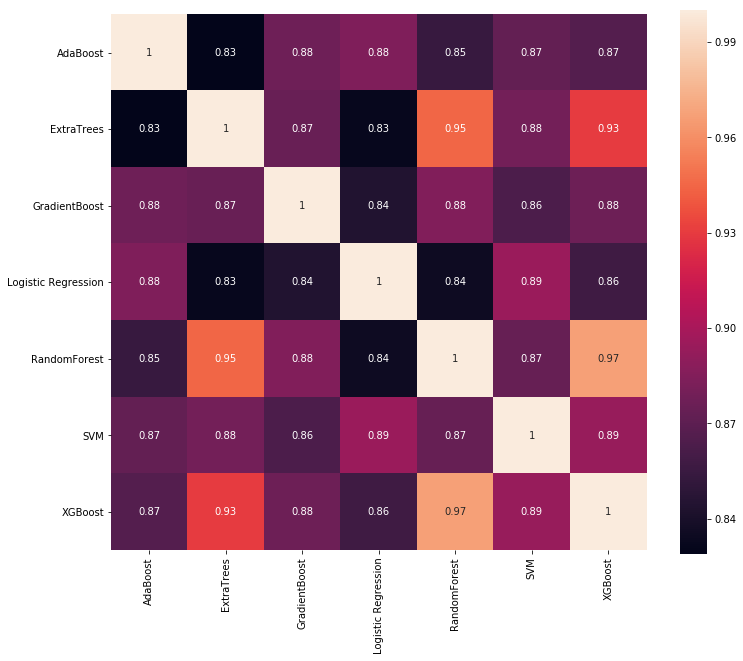

In [80]:
# correlation between model predictions on training data
base_predictions_train = pd.DataFrame( {'RandomForest': rf_best.predict(X_train_[model_cols]),
     'ExtraTrees': et_best.predict(X_train_[model_cols]),
     'AdaBoost': ada_best.predict(X_train_[model_cols]),
     'SVM' : svc_best.predict(X_train_[model_cols]),
     'GradientBoost': gb_best.predict(X_train_[model_cols]),
     'Logistic Regression': log_best.predict(X_train_[model_cols]),
     'XGBoost': xgbm_best.predict(X_train_[model_cols])
    })

plt.figure(figsize=(12,10))
foo = sns.heatmap(base_predictions_train.corr(), vmax=1.0, square=True, annot=True)

In [81]:
# Voting classifier
clf_vote = VotingClassifier(
    estimators=[
        #('tree', clf_tree),
        ('rf', rf_best),
        ('et', et_best),
        ('ada', ada_best),
        ('gb', gb_best),
        ('xgb', xgbm_best),
        ('svm', svc_best),
        ('logistic', log_best)
        ],
    weights=[2,1,1,2,2,3,1],
    voting='hard')
clf_vote.fit(X_train_[model_cols], y_train_['lapsed_next_period'])

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weigh...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard',
         weights=[2, 1, 1, 2, 2, 3, 1])

In [82]:
clf_vote_score_train = right_classification(y_pred=clf_vote.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
clf_vote_score_train

0.81887366818873664

In [83]:
clf_vote_score_test = right_classification(y_pred=clf_vote.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
clf_vote_score_test

0.78048780487804881

In [84]:
print(confusion_matrix(y_test['lapsed_next_period'], clf_vote.predict(X_test[model_cols])))

[[2222  753]
 [  36  128]]


In [85]:
print(confusion_matrix(y_test['lapsed_next_period'], svc_best.predict(X_test[model_cols])))

[[2155  820]
 [  31  133]]


In [86]:
print(accuracy_score(y_test['lapsed_next_period'], svc_best.predict(X_test[model_cols])))

0.728894552405


In [87]:
print(right_classification(y_test['lapsed_next_period'], svc_best.predict(X_test[model_cols])))

0.810975609756


### the very last test

In [58]:
def acc_recall(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    ac = accuracy_score(y_true, y_pred)
    return 0.45 * ac + 0.65 * (cf[1, 1] / cf[1, :].sum())

def acc_recall_v2(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    ac = accuracy_score(y_true, y_pred)
    rc = cf[1, 1] / cf[1, :].sum()
    return (0.45 * ac + 0.65 * rc) / abs(rc-ac)

new_scoring = {'acc_recall': make_scorer(acc_recall_v2)}

# SVC parameters
svc_params_gs = {
    'kernel': ['linear', 'rbf'],
    'C': [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 0.01, 0.05]
}

svc_new = GridSearchCV(SVC(), svc_params_gs, cv=5, scoring=new_scoring, refit='acc_recall')

svc_clf_new, svc_ypred_new = classifier_runner(svc_new, X_train_, y_train_['lapsed_next_period'],
                                               X_test, y_test['lapsed_next_period'])

----------------------------------------
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
----------------------------------------
{'C': 0.005, 'kernel': 'linear'}


             precision    recall  f1-score   support

          0       0.98      0.74      0.84      2975
          1       0.14      0.79      0.24       164

avg / total       0.94      0.74      0.81      3139

0.738133163428
[[2187  788]
 [  34  130]]
0.792682926829


In [59]:
print(acc_recall(y_test['lapsed_next_period'], svc_ypred_new))

0.847403825982


In [90]:
from sklearn.externals import joblib

# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(rf_best, filename)

['finalized_model.sav']

In [91]:
loaded_model = joblib.load(filename)

In [94]:
loaded_model.predict(X_test[model_cols].iloc[0:10])

array([0, 1, 1, 0, 0, 1, 1, 0, 0, 0])

In [ ]:
loaded_model.